In [18]:
Sys.setlocale(category = "LC_ALL", locale = "en_US.UTF-8")

[1] "en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/C"

# Dependencies

In [19]:
pacman::p_load(dplyr, ggplot2, ggbeeswarm, ggpubr, ggsignif, cowplot, ComplexHeatmap, factoextra, FactoMineR, VIM, missMDA) 

# Functions

In [20]:
source("/Users/anabbi/git/ped_CapTCRseq/R/ggplot2_theme.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/color_schemes.R")
source("/Users/anabbi/git/ped_CapTCRseq/R/Misc_functions.R")

# Paths

In [21]:
datapath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Data/"
plotpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Plots/"
manifestpath <- "/Users/anabbi/OneDrive - UHN/Documents/INTERCEPT/Manifests/"
gitpath <- "/Users/anabbi/git/ped_CapTCRseq/"

In [22]:
h4hpath <- "/Users/anabbi/Desktop/H4H/INTERCEPT/"

# Main

In [23]:
pbmc_hla_v_j_gliph <- readr::read_rds(paste0(datapath, "/int_pbmc_hla_v_j_gliph.rds"))

In [24]:
rownames(pbmc_hla_v_j_gliph) <- pbmc_hla_v_j_gliph$sample_id

In [25]:
dim(pbmc_hla_v_j_gliph)

[1]  534 8829

In [26]:
table(pbmc_hla_v_j_gliph$Relapse)


  0   1 
431 103 

In [67]:
cols_tbv <- colnames(pbmc_hla_v_j_gliph)[which(grepl("TRBV", colnames(pbmc_hla_v_j_gliph)) ) ]
cols_tbj <- colnames(pbmc_hla_v_j_gliph)[which(grepl("TRBJ", colnames(pbmc_hla_v_j_gliph)) ) ]
cols_flow <- c('ATC', 'Naïve%','SCM%','CM%','EM%','PD1%','LAG3%')
cols_others <- "observed_Shannon"
# cols_hla <- colnames(pbmc_hla_v_j_gliph)[which(grepl(":0", colnames(pbmc_hla_v_j_gliph)) ) ]

In [68]:
# cols_gliph <- colnames(pbmc_hla_v_j_gliph)[274:ncol(pbmc_hla_v_j_gliph)]

In [69]:
pbmc_hla_v_j_gliph$cyclenum <- as.numeric(gsub("X0", "", pbmc_hla_v_j_gliph$cycle))

In [70]:
mymat <- pbmc_hla_v_j_gliph[, c(cols_flow, cols_others)]

In [71]:
rownames(mymat) <- pbmc_hla_v_j_gliph[["sample_id"]]
# remove rows with all NAs
mymat <- mymat[rowSums(is.na(mymat)) != ncol(mymat), ]
# rmeove those with only 0s and NAs
mymat <- mymat[rowSums(mymat, na.rm = TRUE) != 0, ]


In [72]:
pbmc_hla_v_j_gliph <- pbmc_hla_v_j_gliph[rownames(mymat), ]

In [73]:
mymat_narm <- mymat[rowSums(is.na(mymat)) == 0, ]

In [74]:
# myvars <- sort(Rfast::colVars(mymat_narm), decreasing = TRUE)
# mymat_narm <- mymat_narm[, names(myvars)[myvars > 0]]

In [42]:
df_narm <- pbmc_hla_v_j_gliph[rownames(mymat_narm), ]

In [43]:
dim(df_narm)

[1]  103 8830

In [44]:
mymat_narm_pre <- mymat_narm[grepl("_01", rownames(mymat_narm)), ]
mymat_narm_post <- mymat_narm[!grepl("_01", rownames(mymat_narm)), ]

In [45]:
df_narm_pre <- df_narm[ rownames(mymat_narm_pre), ]
df_narm_post <- df_narm[ rownames(mymat_narm_post), ]

In [46]:
pca_pre <- prcomp(mymat_narm_pre, center = TRUE, scale. = TRUE)
pca_post <- prcomp(mymat_narm_post, center = TRUE, scale. = TRUE)

In [47]:
# fviz_eig(pca, ncp = 10)

In [48]:
pre_p <- fviz_pca_ind(pca_pre,
     col.ind = as.vector(df_narm_pre$Relapse),
    # gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
    # remove labels
    label = "none",
    repel = TRUE, addEllipses = FALSE, mean.point = FALSE
)

post_p <- fviz_pca_ind(pca_post,
     col.ind = as.vector(df_narm_post$Relapse),
    # gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
    # remove labels
    label = "none",
    repel = TRUE, addEllipses = FALSE, mean.point = FALSE
)

In [49]:
match(df_narm_pre$sample_id, rownames(pca_pre$x) )

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34

In [50]:
df_narm_pre$Dim1 <- pca_pre$x[, 1]
df_narm_pre$Dim2 <- pca_pre$x[, 2]

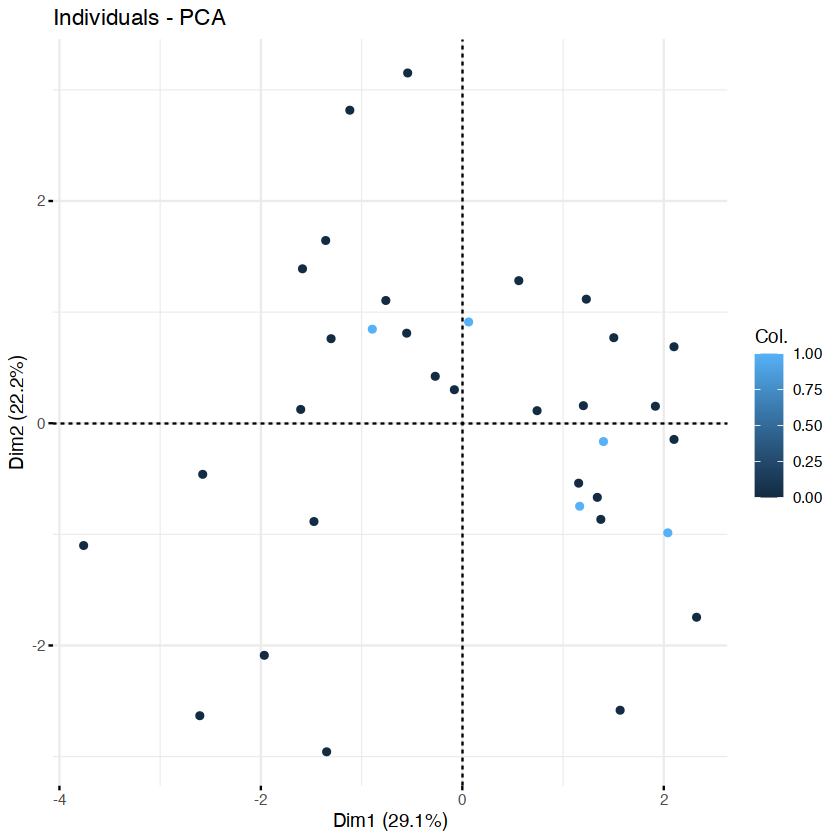

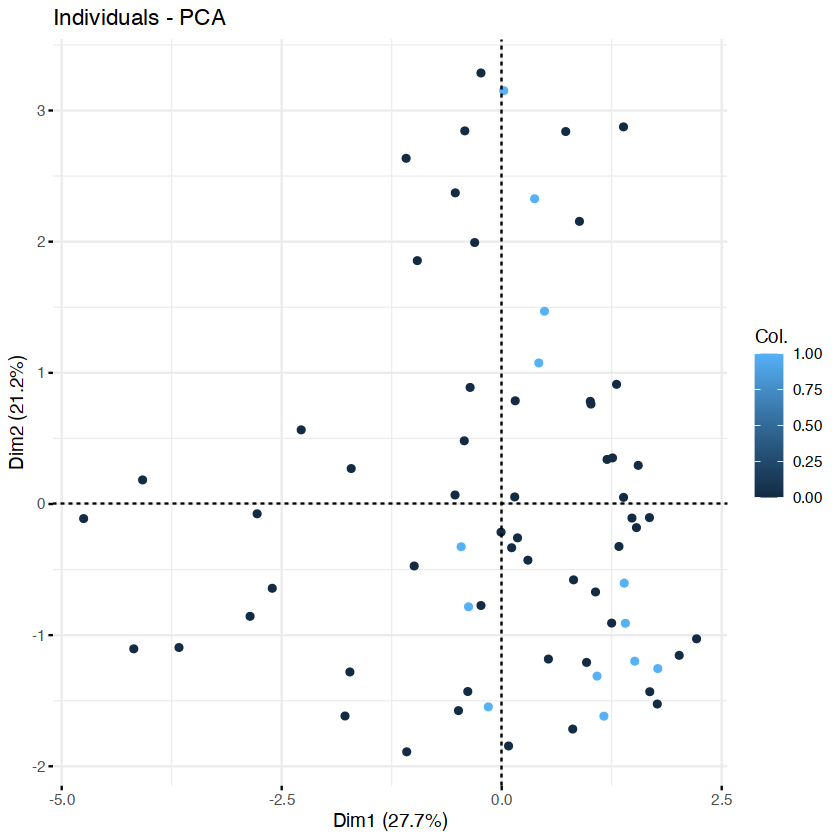

In [51]:
pre_p
post_p

In [52]:

    myx <- pca_post$x
    mydist <- as.matrix(dist(myx[, 1:2]))
    # print(head(mydist) )
    sample_df_narm <- df_narm_post %>%
        group_by(Patient) %>%
        # order cyclenum
        arrange(cyclenum) %>%
        ungroup()
    pts <- names(which(table(sample_df_narm$Patient) > 1))
    sample_df_narm$dist <- NA
    for (i in pts) {
        tmp <- sample_df_narm[sample_df_narm$Patient == i, ]
        distances_df <- mydist[tmp$sample_id, tmp$sample_id]
        if (nrow(tmp) == 2) {
            mydiff <- diff(tmp$cyclenum)
            if (mydiff == 1) {
                tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
            }
        }
        if (nrow(tmp) == 3) {
            mydiff <- diff(tmp$cyclenum)
            if (mydiff[1] == 1) {
                tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
            }
            if (mydiff[2] == 1) {
                tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
            }
        }
        if (nrow(tmp) == 4) {
            mydiff <- diff(tmp$cyclenum)
            if (mydiff[1] == 1) {
                tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
            }
            if (mydiff[2] == 1) {
                tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
            }
            if (mydiff[3] == 1) {
                tmp$dist[4] <- distances_df[tmp$sample_id[3], tmp$sample_id[4]]
            }
        }
        if (nrow(tmp) == 5) {
            mydiff <- diff(tmp$cyclenum)
            if (mydiff[1] == 1) {
                tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
            }
            if (mydiff[2] == 1) {
                tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
            }
            if (mydiff[3] == 1) {
                tmp$dist[4] <- distances_df[tmp$sample_id[3], tmp$sample_id[4]]
            }
            if (mydiff[4] == 1) {
                tmp$dist[5] <- distances_df[tmp$sample_id[4], tmp$sample_id[5]]
            }
        }
        sample_df_narm$dist[sample_df_narm$Patient == i] <- tmp$dist
    }
    # message("sample_df_narm")
    # print(head(sample_df_narm))
    allpts <- as.data.frame(table(sample_df_narm$Patient), stringsAsFactors = F)
    sample_df_narm$dist[sample_df_narm$dist == 0] <- NA
    allpts$sumdist <- NA
    allpts$meddist <- NA
    allpts$samplecount <- NA
    for (i in 1:nrow(allpts)) {
        tmp <- as.data.frame(sample_df_narm[sample_df_narm$Patient == allpts$Var1[i], ])
        allpts$sumdist[i] <- sum(tmp[tmp$dist != 0, "dist"], na.rm = T)
        allpts$meddist[i] <- median(tmp[tmp$dist != 0, "dist"], na.rm = T)
        allpts$samplecount[i] <- nrow(tmp[!is.na(tmp$dist), ]) + 1
    }
    allpts$sumdist_n <- allpts$sumdist / allpts$samplecount
    allpts$meddist_n <- allpts$meddist / allpts$samplecount

    allpts_no0 <- allpts[allpts$sumdist_n > 0, ]
    allpts_no0 <- allpts_no0[allpts_no0$Freq > 1, ]

    mysample_df <- sample_df_narm[sample_df_narm$Patient %in% allpts_no0$Var1, ]
    mypatients <- mysample_df[!duplicated(mysample_df$Patient), ]
    mypatients$sumdist_n <- allpts_no0$sumdist_n[match(mypatients$Patient, allpts_no0$Var1)]
    mypatients$sumdist <- allpts_no0$sumdist[match(mypatients$Patient, allpts_no0$Var1)]
    mypatients$meddist_n <- allpts_no0$meddist_n[match(mypatients$Patient, allpts_no0$Var1)]
    mypatients$meddist <- allpts_no0$meddist[match(mypatients$Patient, allpts_no0$Var1)]


In [53]:
(allpts_no0)

,Var1,Freq,sumdist,meddist,samplecount,sumdist_n,meddist_n
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,CHP_343,4,4.7144442,1.2684180,4,1.1786111,0.3171045
2,CHP_347,4,12.8131351,3.4025272,4,3.2032838,0.8506318
5,CHP_350,4,6.8358327,2.0758367,4,1.7089582,0.5189592
8,CHP_356,3,1.6826338,1.6826338,2,0.8413169,0.8413169
9,CHP_357,4,10.4190634,3.3252504,4,2.6047658,0.8313126
11,CHP_361,2,0.5139874,0.5139874,2,0.2569937,0.2569937
21,CHP_391,2,0.4080109,0.4080109,2,0.2040055,0.2040055
26,CHP_398,2,0.8054343,0.8054343,2,0.4027172,0.4027172
27,CHP_399,2,3.9904131,3.9904131,2,1.9952066,1.9952066


In [54]:
df_narm_pre$meddist_n <- allpts_no0$meddist_n[ match(df_narm_pre$Patient, allpts_no0$Var1)]

In [55]:
df_narm_pre

,sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,S%P,G%GE,S%G,%YE,%G,%E,cyclenum,Dim1,Dim2,meddist_n
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP_346_01,CHP_346_01,CHP_346,X01,0.8,331.70,1.0,NB,0.8,637,0,...,0,0,0,0,0,0,1,-0.54241952,3.1521536,NA
CHP_347_01,CHP_347_01,CHP_347,X01,0.8,126.72,13.0,ALL,0.8,1701,1,...,0,0,0,0,0,0,1,1.20198306,0.1580219,0.8506318
CHP_348_01,CHP_348_01,CHP_348,X01,11.5,50.96,18.0,OS,11.5,1125,28,...,0,0,0,0,0,0,1,-0.26875354,0.4223610,NA
CHP_349_01,CHP_349_01,CHP_349,X01,2.0,3152.22,17.0,CML,2.0,2735,53,...,0,0,0,0,0,0,1,2.04029336,-0.9861285,NA
CHP_350_01,CHP_350_01,CHP_350,X01,2.7,1615.44,1.0,HB,2.7,1338,18,...,0,0,0,0,0,0,1,0.56076953,1.2831236,0.5189592
CHP_352_01,CHP_352_01,CHP_352,X01,1.2,763.14,17.0,HR ALL,1.2,2337,2,...,0,0,0,0,0,0,1,2.10192042,-0.1456999,NA
CHP_353_01,CHP_353_01,CHP_353,X01,0.9,344.00,6.0,AML,0.9,2376,19,...,0,0,0,0,0,0,1,1.40131525,-0.1647018,NA
CHP_354_01,CHP_354_01,CHP_354,X01,2.4,5252.80,9.0,AML,2.4,2454,2,...,0,0,0,0,0,0,1,1.56683028,-2.5828230,NA
CHP_357_01,CHP_357_01,CHP_357,X01,1.7,251.00,1.0,AML,1.7,1382,2,...,0,0,0,0,0,0,1,-0.07895048,0.3017202,0.8313126


In [ ]:
# umaplayout <- as.data.frame(umap::umap(mymat_narm_X01)$layout )

In [ ]:
# umaplayout$cancergroup <- df_narm_X01$cancergroup # orders are the same
# umaplayout$Patient <- df_narm_X01$Patient
# umaplayout$cycle <- df_narm_X01$cycle

In [ ]:
# head(umaplayout)

,V1,V2,cancergroup,Patient,cycle
,<dbl>,<dbl>,<chr>,<chr>,<chr>
CHP_346_01,-0.8483028,0.9259161,Solid tumors,CHP_346,X01
CHP_347_01,-2.0197571,0.6349436,Leukemia,CHP_347,X01
CHP_348_01,-2.6215086,0.3878308,Solid tumors,CHP_348,X01
CHP_349_01,2.5741145,-0.6255879,Leukemia,CHP_349,X01
CHP_350_01,2.4738871,-0.1368852,Solid tumors,CHP_350,X01
CHP_352_01,1.4077899,0.2404501,Leukemia,CHP_352,X01


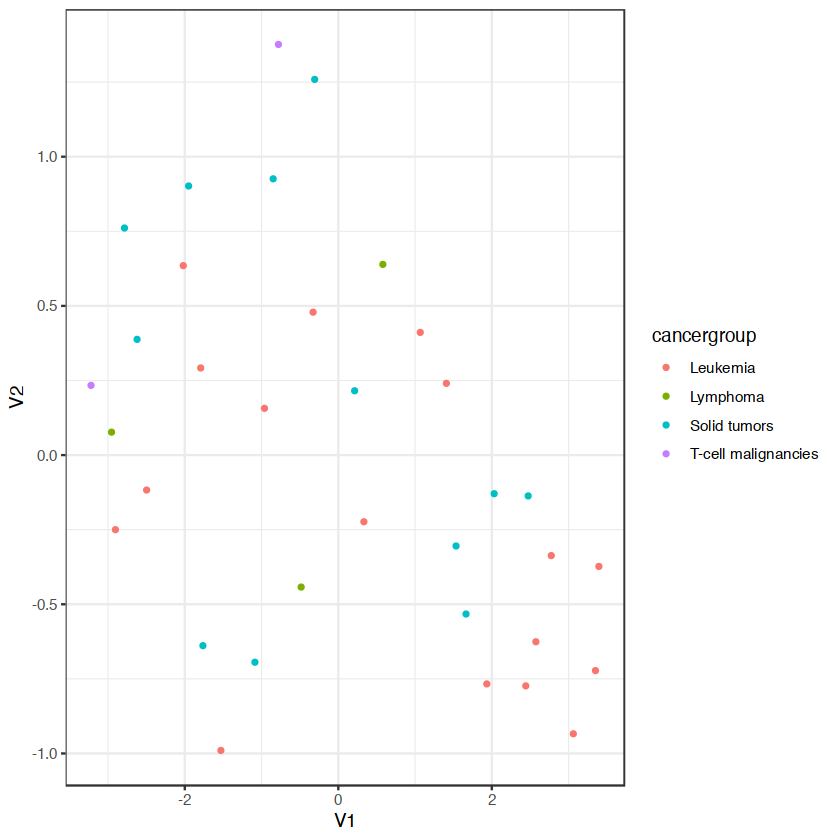

In [ ]:
# ggplot(umaplayout, aes(x = V1, y = V2, color = cancergroup)) + geom_point(size = 1) + theme_bw()

Impute

In [75]:
mymat_pre <- mymat[grepl("_01", rownames(mymat)), ]
mymat_post <- mymat[!grepl("_01", rownames(mymat)), ]

In [76]:
df_pre <- pbmc_hla_v_j_gliph[ rownames(mymat_pre), ]
df_post <- pbmc_hla_v_j_gliph[ rownames(mymat_post), ]

In [77]:
set.seed(123)
estimatenp_pre <- estim_ncpPCA(mymat_pre,
    ncp.min = 2, ncp.max = 5, scale = TRUE,
    method.cv = "Kfold", nbsim = 100, pNA = 0.01, threshold = 1e-4
)

estimatenp_post <- estim_ncpPCA(mymat_post,
    ncp.min = 2, ncp.max = 5, scale = TRUE,
    method.cv = "Kfold", nbsim = 100, pNA = 0.01, threshold = 1e-4
)

  |======================================================================| 100%
  |======================================================================| 100%


In [78]:
estimatenp_pre
estimatenp_post

$ncp
[1] 2

$criterion
      2       3       4       5 
1063276 1712246 1884305 1796106

$ncp
[1] 2

$criterion
       2        3        4        5 
415672.9 501632.5 557403.3 462182.7

In [97]:
set.seed(123)
res.comp_pre <- imputePCA(mymat_pre, ncp = 7, maxiter = 1000)
res.comp_post <- imputePCA(mymat_post, ncp = 7, maxiter = 1000)

In [98]:
res.pca_pre <- PCA(res.comp_pre$completeObs, quali.sup = NULL, ncp = 5, graph = FALSE) 
res.pca_post <- PCA(res.comp_post$completeObs, quali.sup = NULL, ncp = 5, graph = FALSE)

In [99]:
match(df_pre$sample_id, rownames(res.pca_pre$ind$coord) )

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
[26] 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
[51] 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75
[76] 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93

In [100]:
df_pre$Dim1 <- res.pca_pre$ind$coord[, 1]
df_pre$Dim2 <- res.pca_pre$ind$coord[, 2]

In [107]:
p1_pre <- fviz_pca_ind(res.pca_pre,
     habillage = as.factor(df_pre$cancergroup),
    label = "none",
    repel = F, addEllipses = FALSE, mean.point = FALSE
)

p1_post <- fviz_pca_ind(res.pca_post, axes = c(5,4),
     habillage = as.factor(df_post$cancergroup),
    label = "none",
    repel = F, addEllipses = FALSE, mean.point = FALSE
)


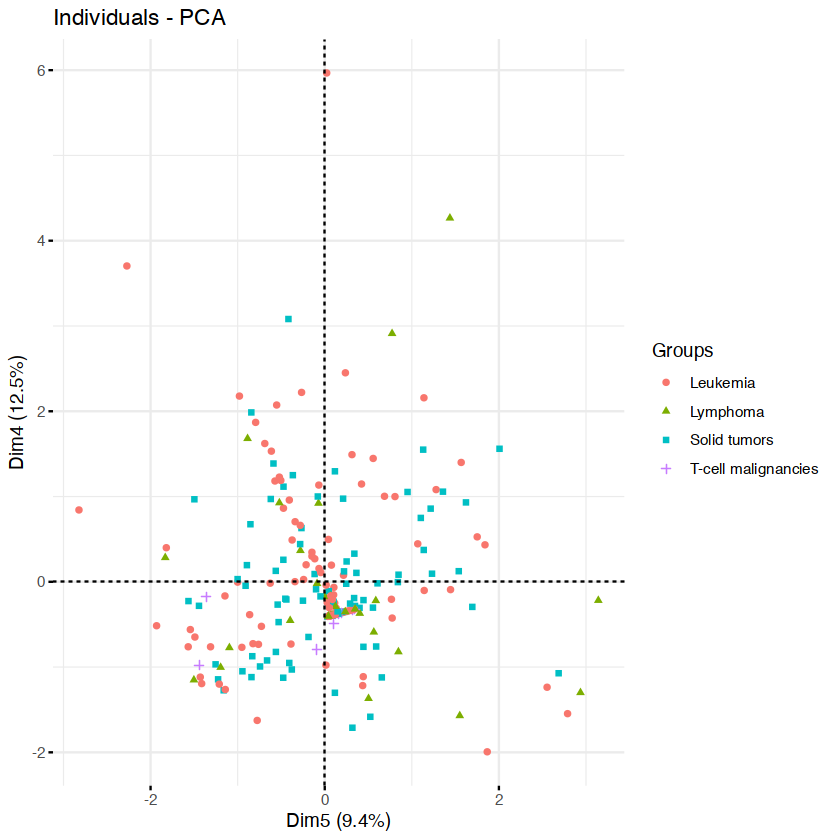

In [108]:
p1_post

In [ ]:
myx <- res.pca_post$ind$coord
mydist <- as.matrix(dist(myx[,1:2])) 

In [ ]:
head(myx)

,Dim.1,Dim.2
CHP_319_05,0.8345717,-1.00428103
CHP_323_03,1.3702292,0.37820169
CHP_323_05,1.2743987,0.85480132
CHP_324_05,0.1218592,-0.57576511
CHP_328_04,-0.3295694,-0.02073135
CHP_328_05,0.4592576,-0.58099257


In [ ]:
sample_df <- df_post %>%
    group_by(Patient) %>%
    # order cyclenum
    arrange(cyclenum) %>%
    ungroup()
pts <- names(which(table(sample_df$Patient) > 1))
sample_df$dist <- NA


In [ ]:
for (i in pts) {
    tmp <- sample_df[sample_df$Patient == i, ]
    distances_df <- mydist[tmp$sample_id, tmp$sample_id]
    if (nrow(tmp) == 2) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
    }
    if (nrow(tmp) == 3) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff[1] == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
        if (mydiff[2] == 1) {
            tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
        }
    }
    if (nrow(tmp) == 4) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff[1] == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
        if (mydiff[2] == 1) {
            tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
        }
        if (mydiff[3] == 1) {
            tmp$dist[4] <- distances_df[tmp$sample_id[3], tmp$sample_id[4]]
        }
    }
    if (nrow(tmp) == 5) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff[1] == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
        if (mydiff[2] == 1) {
            tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
        }
        if (mydiff[3] == 1) {
            tmp$dist[4] <- distances_df[tmp$sample_id[3], tmp$sample_id[4]]
        }
        if (mydiff[4] == 1) {
            tmp$dist[5] <- distances_df[tmp$sample_id[4], tmp$sample_id[5]]
        }
    }
    sample_df$dist[sample_df$Patient == i] <- tmp$dist
}


In [ ]:
allpts <- as.data.frame(table(sample_df$Patient), stringsAsFactors = F)
sample_df$dist[sample_df$dist == 0] <- NA
allpts$sumdist <- NA
allpts$meddist <- NA
allpts$samplecount <- NA
for (i in 1:nrow(allpts)) {
    tmp <- as.data.frame(sample_df[sample_df$Patient == allpts$Var1[i], ])
    allpts$sumdist[i] <- sum(tmp[tmp$dist != 0, "dist"], na.rm = T)
    allpts$meddist[i] <- median(tmp[tmp$dist != 0, "dist"], na.rm = T)
    # count number of samples for meddist
    allpts$samplecount[i] <- nrow(tmp[!is.na(tmp$dist), ]) + 1 # add 1 for the first sample, this is the number of samples with a distance
}
allpts$sumdist_n <- allpts$sumdist / allpts$samplecount
allpts$meddist_n <- allpts$meddist / allpts$samplecount
allpts_no0 <- allpts[allpts$sumdist_n > 0, ]
allpts_no0 <- allpts_no0[allpts_no0$Freq > 1, ]

mysample_df <- sample_df[sample_df$Patient %in% allpts_no0$Var1, ]
mypatients <- mysample_df[!duplicated(mysample_df$Patient), ]

mypatients$sumdist_n <- allpts_no0$sumdist_n[match(mypatients$Patient, allpts_no0$Var1)]
mypatients$sumdist <- allpts_no0$sumdist[match(mypatients$Patient, allpts_no0$Var1)]
mypatients$meddist_n <- allpts_no0$meddist_n[match(mypatients$Patient, allpts_no0$Var1)]
mypatients$meddist <- allpts_no0$meddist[match(mypatients$Patient, allpts_no0$Var1)]


In [ ]:
rms::lrm(Relapse ~ meddist_n, data = mypatients)

Logistic Regression Model

rms::lrm(formula = Relapse ~ meddist_n, data = mypatients)

                      Model Likelihood     Discrimination    Rank Discrim.    
                            Ratio Test            Indexes          Indexes    
Obs            67    LR chi2      5.74     R2       0.139    C       0.630    
 0             56    d.f.            1     R2(1,67) 0.068    Dxy     0.260    
 1             11    Pr(> chi2) 0.0166    R2(1,27.6)0.158    gamma   0.260    
max |deriv| 4e-09                          Brier    0.119    tau-a   0.072    

          Coef    S.E.   Wald Z Pr(>|Z|)
Intercept -2.5840 0.5729 -4.51  <0.0001 
meddist_n  0.9630 0.4038  2.39  0.0171  


In [ ]:
head(myx)

,Dim.1,Dim.2
CHP_319_05,0.8345717,-1.00428103
CHP_323_03,1.3702292,0.37820169
CHP_323_05,1.2743987,0.85480132
CHP_324_05,0.1218592,-0.57576511
CHP_328_04,-0.3295694,-0.02073135
CHP_328_05,0.4592576,-0.58099257


In [ ]:
sample_df$Dim1 <- myx[ match(sample_df$sample_id, rownames(myx)), 1]
sample_df$Dim2 <- myx[ match(sample_df$sample_id, rownames(myx)), 2]

In [ ]:
sample_df[ sample_df$Relapse == 1,]

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,S%P,G%GE,S%G,%YE,%G,%E,cyclenum,dist,Dim1,Dim2
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP_349_02,CHP_349,X02,13.0,353.06,17,CML,13.0,2767,717,...,0,0,0,0,0,0,2,NA,1.2598135,-0.10878714
CHP_356_02,CHP_356,X02,1.1,0.00,9,EWS,1.1,1028,66,...,0,0,0,0,0,0,2,NA,-1.5496775,-1.62201684
CHP_359_02,CHP_359,X02,0.0,0.00,15,AML,0.0,0,NA,...,0,0,0,0,0,0,2,NA,-1.3972670,0.33760425
CHP_364_02,CHP_364,X02,1.9,0.00,16,OS,1.9,2487,18,...,0,0,0,0,0,0,2,NA,-1.7711105,-2.01189426
CHP_376_02,CHP_376,X02,0.0,0.00,1,AML,0.0,0,NA,...,0,0,0,0,0,0,2,NA,-5.2038223,2.62628243
CHP_377_02,CHP_377,X02,0.0,0.00,18,HR ALL,0.0,0,NA,...,0,0,4,0,0,0,2,NA,-0.9982564,0.09770054
CHP_380_02,CHP_380,X02,0.0,0.00,14,HD,0.0,0,NA,...,0,0,0,0,0,0,2,NA,0.5297514,-0.82100889
CHP_402_02,CHP_402,X02,0.8,419.95,9,HR ALL,0.8,2487,0,...,0,0,0,0,0,0,2,NA,-2.0013859,-2.24301601
CHP_411_02,CHP_411,X02,3.2,0.00,16,HR ALL,3.2,50,1,...,0,0,0,0,0,0,2,NA,-1.1457490,3.58210516


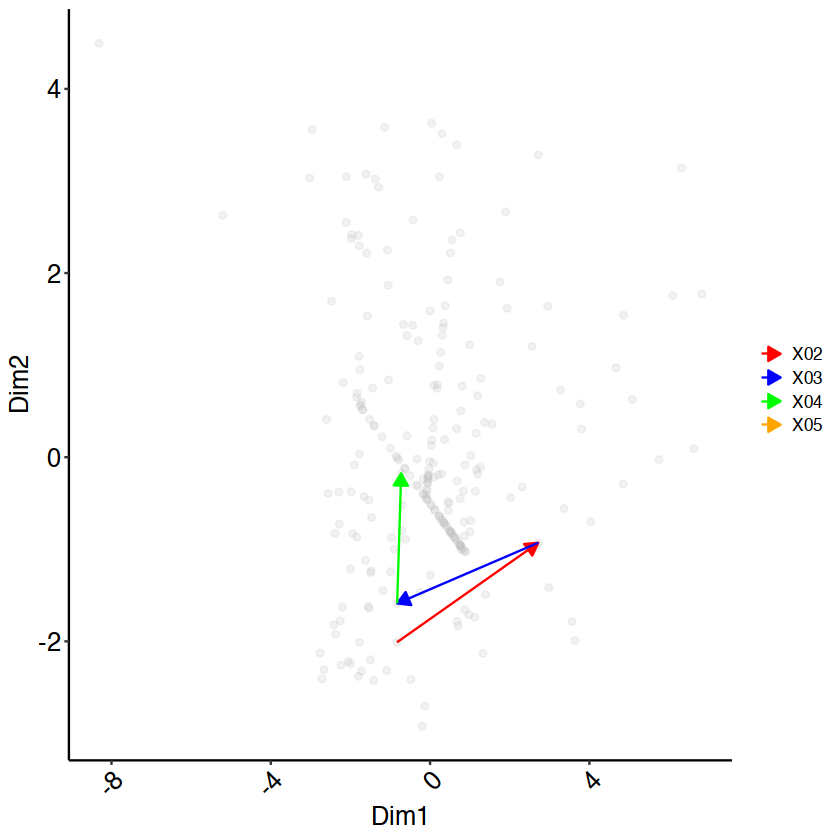

In [ ]:
ggplot(data = sample_df, aes(x = Dim1, y = Dim2)) + geom_point(alpha = 0.2, color = "grey") +
geom_path(data = sample_df[sample_df$Patient %in% c("CHP_418"),], aes(group = Patient, color = cycle), 
arrow = arrow(length=unit(0.30,"cm"), ends="last", type = "closed")) +
myplot + myaxis + scale_color_manual(values = c("red", "blue", "green", 
"orange", "purple", "black", "brown", "pink", "grey", "yellow") )

In [ ]:
tail(mypatients)

sample_id,Patient,cycle,FOLD,ATC,Age,Disease_type,TE_fold,CD3,EM,...,S%G,%YE,%G,%E,cyclenum,dist,sumdist_n,sumdist,meddist_n,meddist
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CHP_392_03,CHP_392,X03,4.0,75.24,8.0,ALL,4.0,2415,16,...,NA,NA,NA,NA,3,NA,1.3709877,2.7419753,1.3709877,2.7419753
CHP_393_03,CHP_393,X03,0.7,44.80,10.0,OS,0.7,165,3,...,NA,NA,NA,NA,3,NA,0.9878258,2.9634774,0.4939129,1.4817387
CHP_398_03,CHP_398,X03,0.9,158.40,6.0,ALL,0.9,2507,88,...,NA,NA,NA,NA,3,NA,1.7847679,5.3543036,0.8923839,2.6771518
CHP_425_03,CHP_425,X03,2.6,0.00,0.5,WILMS,2.6,2374,280,...,NA,NA,NA,NA,3,NA,0.6913064,1.3826128,0.6913064,1.3826128
CHP_331_04,CHP_331,X04,0.0,0.00,5.0,SR ALL,0.0,0,NA,...,0,0,0,0,4,NA,0.2692971,0.5385942,0.2692971,0.5385942
CHP_390_04,CHP_390,X04,NA,1096.68,5.0,OS,NA,0,NA,...,NA,NA,NA,NA,4,NA,0.5069951,1.0139902,0.5069951,1.0139902


In [ ]:
df_pre$meddist_n <- mypatients$meddist_n[ match(df_pre$Patient, mypatients$Patient)]

In [ ]:
df_pre_narm <- df_pre[!is.na(df_pre$meddist_n), ]
df_pre_narm$DimDiff <- df_pre_narm$Dim1 - df_pre_narm$Dim2

In [ ]:
table(df_pre_narm$vital_status)


 0  1 
56  2 

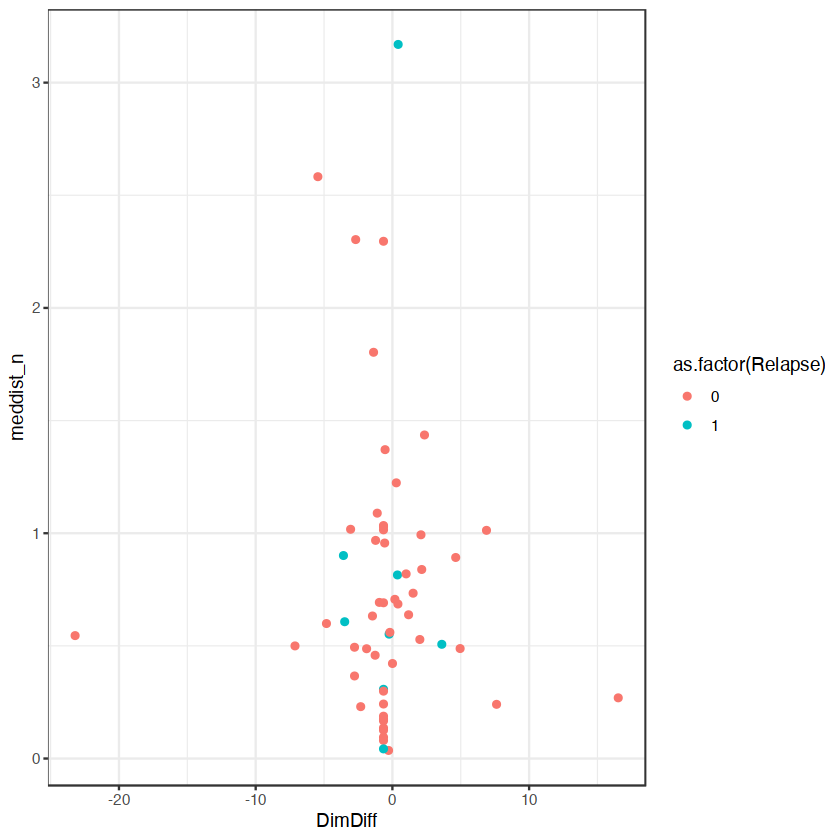

In [ ]:
ggplot(df_pre_narm, aes(x = DimDiff, y = meddist_n, color = as.factor(Relapse)) )+ geom_point() + theme_bw()

In [ ]:
rms::lrm(Relapse ~ Dim1 * Dim2, data = df_pre_narm)

Logistic Regression Model

rms::lrm(formula = Relapse ~ Dim1 * Dim2, data = df_pre_narm)

                      Model Likelihood     Discrimination    Rank Discrim.    
                            Ratio Test            Indexes          Indexes    
Obs            58    LR chi2      0.96     R2       0.030    C       0.603    
 0             50    d.f.            3     R2(3,58) 0.000    Dxy     0.205    
 1              8    Pr(> chi2) 0.8113    R2(3,20.7)0.000    gamma   0.205    
max |deriv| 3e-09                          Brier    0.117    tau-a   0.050    

            Coef    S.E.   Wald Z Pr(>|Z|)
Intercept   -1.8217 0.3921 -4.65  <0.0001 
Dim1        -0.0122 0.2571 -0.05  0.9621  
Dim2         0.3120 0.4330  0.72  0.4711  
Dim1 * Dim2  0.0049 0.1200  0.04  0.9677  


In [ ]:
library(rms)

Loading required package: Hmisc


Attaching package: ‘Hmisc’


The following objects are masked from ‘package:dplyr’:

    src, summarize


The following objects are masked from ‘package:base’:

    format.pval, units




In [ ]:
options(datadist = mypatients)

In [ ]:
lrm(Relapse ~ meddist_n, data = mypatients)

ERROR: Error in exists(XDATADIST): invalid first argument


In [ ]:
sample_df$meddist_n <- allpts_no0$meddist_n[ match(sample_df$Patient, allpts_no0$Var1)]

In [ ]:
sample_df$ave <- rowMeans(sample_df[, c("Dim1", "Dim2")])

Warning message:
“Removed 22 rows containing missing values (`geom_point()`).”


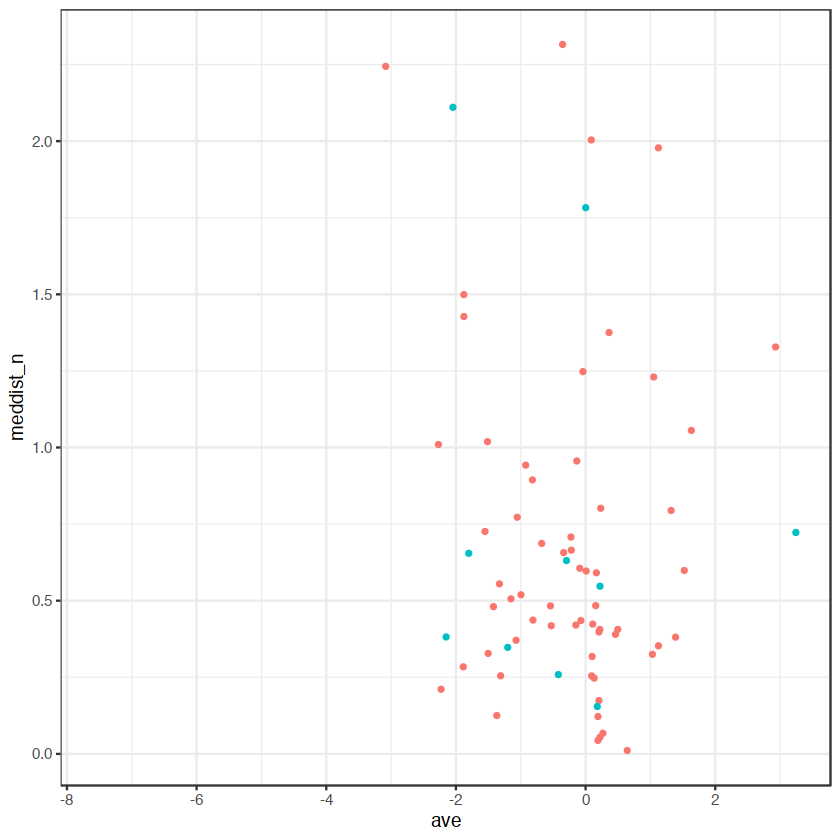

In [ ]:
ggplot(sample_df[ sample_df$cycle == "X01",], aes(x = ave, y = meddist_n, color = as.factor(Relapse))) + geom_point(size = 1) + theme_bw() + theme(legend.position = "none")

`geom_path()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


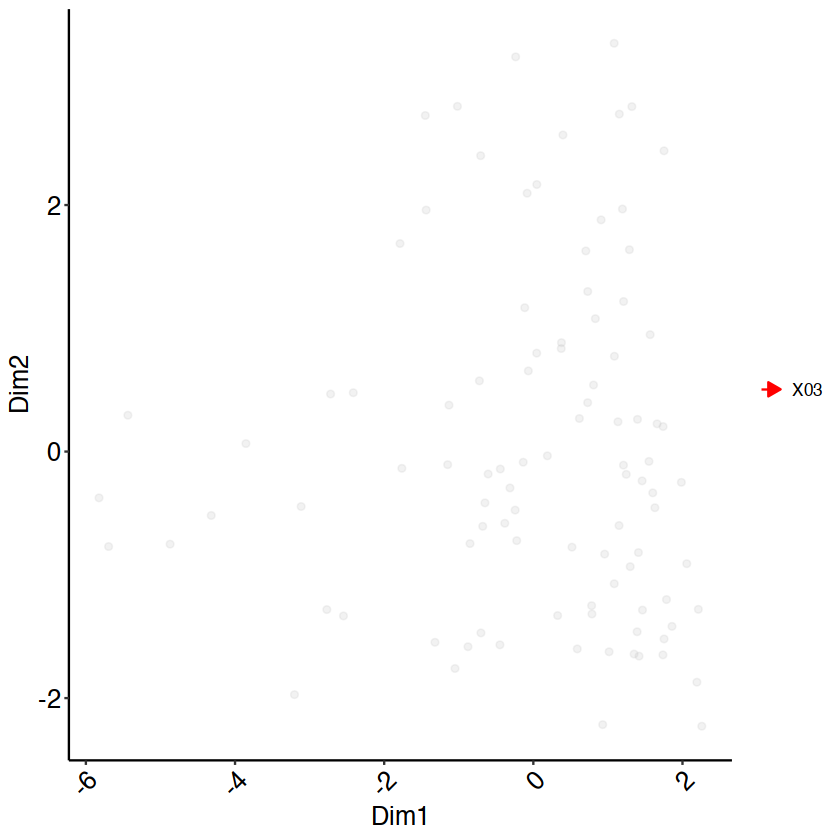

In [ ]:
ggplot(data = sample_df, aes(x = Dim1, y = Dim2)) + geom_point(alpha = 0.2, color = "grey") +
geom_path(data = sample_df[sample_df$Patient %in% c("CHP_385"),], aes(group = Patient, color = cycle), 
arrow = arrow(length=unit(0.30,"cm"), ends="last", type = "closed")) +
myplot + myaxis + scale_color_manual(values = c("red", "blue", "green", 
"orange", "purple", "black", "brown", "pink", "grey", "yellow") )

Main

In [ ]:
myvars <- sort(Rfast::colVars(pbmc_hla_v_j_gliph[,c(cols_gliph, cols_hla, cols_flow, cols_others, cols_tbj, cols_tbv)], na.rm = T), decreasing = TRUE)

In [ ]:
rmcols <- names(myvars)[myvars < 0.25] # 1th percentile

In [ ]:
hist(log10(myvars), breaks = 100)

In [ ]:
summary(myvars)

In [ ]:
# cols_gliph <- cols_gliph[which(!cols_gliph %in% rmcols)] 

In [ ]:
pbmc_flowonly <- imputepca.fx(pbmc_hla_v_j_gliph, c(cols_flow))

In [ ]:
# pbmc_tcronly <- imputepca.fx(pbmc_hla_v_j_gliph, c(cols_others, cols_tbv, cols_tbj)) # no need to impute, there are no NAs
set.seed(123)
# pbmc_tcrhla <- imputepca.fx(pbmc_hla_v_j_gliph, c(cols_others, cols_tbv, cols_tbj, cols_hla))

In [ ]:
pbmc_all <- imputepca.fx(pbmc_hla_v_j_gliph, c(cols_flow, cols_others, cols_tbv, cols_tbj))

In [ ]:
pbmc_flowonly[5:6]

[[1]]
Logistic Regression Model

rms::lrm(formula = Relapse ~ sumdist_n, data = mypatients)

                      Model Likelihood     Discrimination    Rank Discrim.    
                            Ratio Test            Indexes          Indexes    
Obs            53    LR chi2      0.02     R2       0.001    C       0.512    
 0             45    d.f.            1     R2(1,53) 0.000    Dxy     0.025    
 1              8    Pr(> chi2) 0.8764    R2(1,20.4)0.000    gamma   0.025    
max |deriv| 4e-05                          Brier    0.128    tau-a   0.007    

          Coef    S.E.   Wald Z Pr(>|Z|)
Intercept -1.8062 0.6392 -2.83  0.0047  
sumdist_n  0.0431 0.2744  0.16  0.8753  


[[2]]
Logistic Regression Model

rms::lrm(formula = Relapse ~ meddist_n, data = mypatients)

                      Model Likelihood     Discrimination    Rank Discrim.    
                            Ratio Test            Indexes          Indexes    
Obs            53    LR chi2      3.80     R2       0.12

In [ ]:
cfdna_hla_v_j_gliph <- readr::read_rds(paste0(datapath, "/int_cfdna_hla_v_j_gliph.rds"))

In [ ]:
rownames(cfdna_hla_v_j_gliph) <- cfdna_hla_v_j_gliph$sample_id

In [ ]:
dim(cfdna_hla_v_j_gliph)


[1]  274 1495

In [ ]:
table(cfdna_hla_v_j_gliph$Relapse)


  0   1 
226  48 

In [ ]:
cols_tbv <- colnames(cfdna_hla_v_j_gliph)[which(grepl("TRBV", colnames(cfdna_hla_v_j_gliph)) ) ]
cols_tbj <- colnames(cfdna_hla_v_j_gliph)[which(grepl("TRBJ", colnames(cfdna_hla_v_j_gliph)) ) ]
cols_flow <- c('ATC', 'Naïve%','SCM%','CM%','EM%','TE%','PD1%','LAG3%','TIM3%')
cols_others <- c("log10shann")
cols_hla <- colnames(cfdna_hla_v_j_gliph)[which(grepl(":0", colnames(cfdna_hla_v_j_gliph)) ) ]

In [ ]:
which(grepl("TRBJ", colnames(cfdna_hla_v_j_gliph) ) )

[1] 258 259 260 261 262 263 264 265 266 267 268 269 270

In [ ]:
colnames(cfdna_hla_v_j_gliph)[271:ncol(cfdna_hla_v_j_gliph)]

[1] "SLG%E"       "GIWV"        "IWV"         "WVYE"        "IWVY"       
   [6] "S%TGNTE"     "SV%GNTE"     "S%GNYG"      "S%RTGE"      "TGIW"       
  [11] "R%STDT"      "S%GQMNTE"    "SP%MNTE"     "%GTGNTE"     "SPG%TGE"    
  [16] "SA%NTE"      "SLG%NTE"     "S%GSYE"      "RG%GGTE"     "SL%DE"      
  [21] "S%TENTE"     "S%GRTDT"     "S%RGYG"      "SDR%TGE"     "SP%RGNTE"   
  [26] "SPRQG%NTE"   "TG%SYE"      "SP%RNTE"     "S%GVNE"      "SPGP%E"     
  [31] "SY%GTE"      "SP%GYG"      "SPG%GTE"     "SL%GE"       "S%SSYNE"    
  [36] "S%QGATE"     "SAGQ%NTE"    "S%SGE"       "S%PNTE"      "S%SYE"      
  [41] "S%AGANTGE"   "SQDR%T"      "S%MNTE"      "S%GGDG"      "S%SNQP"     
  [46] "S%GYTGE"     "S%GQGSSYE"   "SL%GANTGE"   "S%NTE"       "SP%NTE"     
  [51] "SRGT%YE"     "SL%GATNEK"   "SLT%NTE"     "R%GMNTE"     "S%GTE"      
  [56] "%AGNTE"      "S%GGTE"      "S%GGNE"      "R%TGGTE"     "S%RGPGE"    
  [61] "S%QET"       "S%QNSNQP"    "SPG%YE"      "S%GGTGE"     "SPG%GE"     
  [66] "RQ%GNQP"     "SFG%MNTE"    "S%GTGE"      "SR%GMNTE"    "S%QGGTE"    
  [71] "%GLNYG"      "GS%NTE"      "SSS%E"       "SLGL%YE"     "S%TGGTE"    
  [76] "SFGQ%NTE"    "S%GTGGTGE"   "SLT%MNTE"    "SL%GYE"      "SYS%GE"     
  [81] "SL%GNTE"     "S%GSNQP"     "SIG%GSYE"    "S%GDE"       "SLG%TE"     
  [86] "S%SNTE"      "SS%YE"       "S%NTGE"      "SL%SGE"      "SLGG%E"     
  [91] "SPG%LNTE"    "SY%GTTE"     "SLG%NYG"     "SL%GNE"      "S%GGNQP"    
  [96] "S%TGMNTE"    "SL%TE"       "SL%NE"       "SY%GYE"      "SL%SGGE"    
 [101] "S%RGNE"      "SL%GAGGNT"   "S%RGMNTE"    "S%GQVNTE"    "SL%YE"      
 [106] "%TGGNTE"     "SLD%NTE"     "SLTSG%YNE"   "SL%GTE"      "S%RGTE"     
 [111] "SLGQ%NTE"    "SL%ENTE"     "SPS%TE"      "S%GDNE"      "SLR%NE"     
 [116] "SLGQGA%NTE"  "STGTG%E"     "SLGQ%NEK"    "S%QGNE"      "%VLGDE"     
 [121] "SLTG%TE"     "GQGN%E"      "S%SPGGYE"    "SL%GFNQP"    "SPGQG%DG"   
 [126] "S%SGYE"      "SLG%NE"      "SQDR%G"      "SSG%SGNT"    "SLV%GMNTE"  
 [131] "SPN%E"       "SLG%SYE"     "%LGLNTE"     "SPG%YG"      "S%TGYE"     
 [136] "S%GSTDT"     "SV%GGQET"    "S%GGYG"      "S%GGNT"      "S%SGNT"     
 [141] "S%SMNTE"     "SYS%E"       "S%QGAYE"     "SV%GADE"     "S%GGTTE"    
 [146] "SL%GGNTE"    "SPGTG%YG"    "SL%TDT"      "SL%TGIWVYE"  "SP%EVNTE"   
 [151] "S%RTGSYE"    "%LGNE"       "S%YNE"       "SF%SSYE"     "S%GSE"      
 [156] "SLG%GQP"     "SLVSG%E"     "SL%QGAYE"    "S%QGMNTE"    "SRQG%GTE"   
 [161] "SL%SNQP"     "SL%GTGE"     "SVTG%TE"     "SQD%NQP"     "SLGTGL%G"   
 [166] "%GNTE"       "SSG%TYE"     "SP%TGNYG"    "SL%GGNTGE"   "SYR%E"      
 [171] "SSR%SYE"     "SSG%E"       "S%GAGE"      "SLVG%E"      "S%WNTE"     
 [176] "SGG%YG"      "S%GQGVYE"    "SLR%GE"      "S%GQET"      "SL%RSE"     
 [181] "SPR%NTE"     "SPRT%STDT"   "SLG%ET"      "SL%RNQP"     "S%GLNTE"    
 [186] "SL%GSYE"     "S%RGSYE"     "SLGQG%NTE"   "SL%TGE"      "S%GAGNT"    
 [191] "SSGLAT%E"    "SLG%TNYG"    "%ISGANV"     "SV%GNQP"     "SS%RGKET"   
 [196] "SPSP%NTE"    "SLEGL%TGE"   "S%TGE"       "SL%AGNT"     "SP%TE"      
 [201] "SLG%TDT"     "S%TYE"       "SF%DT"       "S%GGSYE"     "SY%GE"      
 [206] "STGD%"       "RGTG%TE"     "S%GPYE"      "SP%TGE"      "SLE%TE"     
 [211] "SL%SE"       "STR%TE"      "S%SGKNTE"    "GQGNY%"      "SQ%SGNT"    
 [216] "SLGG%QP"     "RG%LNTE"     "RTG%NTE"     "S%GDSSYE"    "S%DSNSP"    
 [221] "SFTG%TE"     "SL%QGGTE"    "S%RLNTE"     "S%DSGGYNE"   "SYSG%"      
 [226] "SQDRR%"      "SPGT%NTE"    "SQ%MNTE"     "SLGQ%NYG"    "SPG%NQP"    
 [231] "S%STDT"      "SLGV%E"      "S%GQGTE"     "SLA%NTGE"    "SV%MNTE"    
 [236] "SLAGG%VYE"   "S%GGGNSP"    "S%GQRNTE"    "SL%GMNTE"    "SSP%AGNTE"  
 [241] "SLRPP%I"     "SVG%QAGDT"   "SFKRGFSG%NV" "SLV%GE"      "S%TGGNTE"   
 [246] "S%NRNTE"     "SFG%NQP"     "SPG%VNTE"    "SAGTGG%YE"   "S%TSGETDT"  
 [251] "SDS%TGE"     "G%MNTE"      "SL%GTYNE"    "SLR%TE"      "SRGG%YE"    
 [256] "S%SGENTGE"   "SVEG%TE"     "SLSG%YNE"    "SS%ISGNT"    "S%GGSSYE"   

In [ ]:
cols_gliph <- colnames(cfdna_hla_v_j_gliph)[271:ncol(cfdna_hla_v_j_gliph)]

In [ ]:
cfdna_hla_v_j_gliph$cyclenum <- as.numeric(gsub("X0", "", cfdna_hla_v_j_gliph$cycle))

In [ ]:
# cfdna_flowonly <- imputepca.fx(cfdna_hla_v_j_gliph, c(cols_flow))

In [ ]:
# cfdna_tcrhla <- imputepca.fx(cfdna_hla_v_j_gliph, c(cols_others, cols_tbv, cols_tbj))

In [ ]:
cfdna_all <- imputepca.fx(cfdna_hla_v_j_gliph, c(cols_flow, cols_others, cols_tbv))

In [ ]:
cfdna_all[5:6]

[[1]]
Logistic Regression Model

rms::lrm(formula = Relapse ~ sumdist_n, data = mypatients)

                      Model Likelihood     Discrimination    Rank Discrim.    
                            Ratio Test            Indexes          Indexes    
Obs            71    LR chi2      0.61     R2       0.014    C       0.600    
 0             57    d.f.            1     R2(1,71) 0.000    Dxy     0.199    
 1             14    Pr(> chi2) 0.4346    R2(1,33.7)0.000    gamma   0.199    
max |deriv| 5e-05                          Brier    0.157    tau-a   0.064    

          Coef    S.E.   Wald Z Pr(>|Z|)
Intercept -1.1315 0.4580 -2.47  0.0135  
sumdist_n -0.1340 0.1829 -0.73  0.4638  


[[2]]
Logistic Regression Model

rms::lrm(formula = Relapse ~ meddist_n, data = mypatients)

                      Model Likelihood     Discrimination    Rank Discrim.    
                            Ratio Test            Indexes          Indexes    
Obs            71    LR chi2      0.24     R2       0.00

# Impute with rms

In [ ]:
pacman::p_load(rms)

In [ ]:
dim(mymat_post)
dim(df_post)

[1] 241  10

[1]  241 8830

In [ ]:
colnames(mymat_post) <- gsub("%", "_p", colnames(mymat_post))
colnames(df_post) <- gsub("%", "_p", colnames(df_post))

In [ ]:
mycols <- c(cols_flow, cols_others)
mycols <- gsub("%", "_p", mycols)

In [ ]:
mycols

[1] "ATC"              "Naïve_p"          "SCM_p"            "CM_p"            
 [5] "EM_p"             "TE_p"             "PD1_p"            "LAG3_p"          
 [9] "TIM3_p"           "observed_Shannon"

In [ ]:
ipc_r <- prcomp( formula( paste("~", paste(mycols), collapse = "+" ) ), data = mymat_post)

In [ ]:
as.formula( paste("~", paste(mycols, collapse = "+") ) )

~ATC + Naïve_p + SCM_p + CM_p + EM_p + TE_p + PD1_p + LAG3_p + 
    TIM3_p + observed_Shannon

In [ ]:
ptrans <- transcan(  as.formula( paste("~ ", paste(c("observed_Shannon","Naïve_p","SCM_p", "CM_p","EM_p","LAG3_p","PD1_p", "ATC"), collapse = "+") ) ) ,
imputed=TRUE , transformed =TRUE , data= mymat_post , pl= FALSE , pr= FALSE, iter.max = 1000)

In [ ]:
trans <- ptrans$transformed

In [ ]:
imp <- impute(ptrans , data= mymat_post , list.out= TRUE)



Imputed missing values with the following frequencies
 and stored them in variables with their original names:

observed_Shannon          Naïve_p            SCM_p             CM_p 
              88              109              109              109 
            EM_p           LAG3_p            PD1_p              ATC 
             109              112              112                2 


In [ ]:
names(imp)

[1] "observed_Shannon" "Naïve_p"          "SCM_p"            "CM_p"            
[5] "EM_p"             "LAG3_p"           "PD1_p"            "ATC"

In [ ]:
NAvars <- all.vars( as.formula( paste("~", paste(names(imp), collapse = "+") ) ))

In [ ]:
NAvars

[1] "observed_Shannon" "Naïve_p"          "SCM_p"            "CM_p"            
[5] "EM_p"             "LAG3_p"           "PD1_p"            "ATC"

In [ ]:
for(x in NAvars ) mymat_post[[x]] <- imp[[x]]

In [ ]:
pca <- prcomp(mymat_post)

ERROR: Error in svd(x, nu = 0, nv = k): infinite or missing values in 'x'


In [ ]:
head(mymat_post)

,ATC,Naïve_p,SCM_p,CM_p,EM_p,TE_p,PD1_p,LAG3_p,TIM3_p,observed_Shannon
,<dbl>,<impute>,<impute>,<impute>,<impute>,<dbl>,<impute>,<impute>,<dbl>,<dbl>
CHP_319_05,0.00,0.5683605,1.810487,49.004371,4.824971,NA,45.0229709,36.768343,NA,11.878
CHP_323_03,786.24,0.0000000,1.948590,49.004371,3.478536,NA,45.0229709,36.768343,NA,37.722
CHP_323_05,979.50,39.0626652,76.591154,1.921128,13.963253,NA,17.2593332,2.192318,NA,81.753
CHP_324_05,0.00,50.8891349,3.199104,0.000000,4.242280,NA,0.8523070,0.462963,NA,129.919
CHP_328_04,130.82,46.8415262,2.638178,0.000000,3.422228,NA,0.4744359,0.462963,NA,223.747
CHP_328_05,91.16,38.4261274,7.635638,0.000000,8.952722,NA,6.9267577,1.144348,NA,87.321


In [ ]:
table(sample_df$Relapse)


  0   1 
201  40 

In [ ]:
trans_fit <- lrm(Relapse ~ trans, data = df_post)

In [ ]:
trans_fit

Logistic Regression Model

lrm(formula = Relapse ~ trans, data = df_post)

                      Model Likelihood      Discrimination    Rank Discrim.    
                            Ratio Test             Indexes          Indexes    
Obs           241    LR chi2      2.51      R2       0.017    C       0.575    
 0            201    d.f.            8      R2(8,241)0.000    Dxy     0.151    
 1             40    Pr(> chi2) 0.9612    R2(8,100.1)0.000    gamma   0.152    
max |deriv| 1e-13                           Brier    0.137    tau-a   0.042    

                 Coef    S.E.   Wald Z Pr(>|Z|)
Intercept        -1.6268 0.1906 -8.54  <0.0001 
observed_Shannon -0.0427 0.3249 -0.13  0.8954  
Naïve_p           0.1252 0.2280  0.55  0.5829  
SCM_p            -0.0520 0.1998 -0.26  0.7949  
CM_p              0.1778 0.2846  0.62  0.5322  
EM_p              0.0485 0.2128  0.23  0.8197  
LAG3_p            0.0174 0.1979  0.09  0.9301  
PD1_p            -0.1998 0.2887 -0.69  0.4890  
ATC         

In [ ]:
myf <- as.formula( paste("Relapse ~", paste(mycols[!grepl("TE", mycols)], collapse = "+") ) )

In [ ]:
raw_fit <- lrm( myf, data = df_post ) 

In [ ]:
AIC(trans_fit)
AIC(raw_fit)

[1] 232.1218

[1] 121.5311

In [ ]:
pca_raw <- prcomp( sample_df[,mycols[!grepl("TIM3", mycols)] ])$x[,1:5]

ERROR: Error in array(x, c(length(x), 1L), if (!is.null(names(x))) list(names(x), : 'data' must be of a vector type, was 'NULL'


In [ ]:
pca_trans <- prcomp( trans[,mycols[!grepl("TIM3", mycols)] ])$x[,1:5]

In [ ]:
pcaraw_fit <- lrm( Relapse ~ pca_raw, data = sample_df ) 
pcatrans_fit <- lrm(Relapse ~ pca_trans, data = sample_df )

In [ ]:
AIC(pcaraw_fit)
AIC(pcatrans_fit)

# Backup

In [ ]:
mymat <- pbmc_hla_v_j_gliph[, c(66,200:270)]
mymat <- cbind(mymat, pbmc_hla_v_j_gliph[,c('ATC', 'Naïve%','SCM%','CM%','EM%','TE%','PD1%','LAG3%','TIM3%')])
# mymat <- pbmc_hla_v_j_gliph[,c('ATC', 'Naïve%','SCM%','CM%','EM%','TE%','PD1%','LAG3%','TIM3%')]
rownames(mymat) <- pbmc_hla_v_j_gliph$sample_id

In [ ]:
head(mymat, 10)

In [ ]:
# remove rows with all NAs
mymat <- mymat[ rowSums(is.na(mymat)) != ncol(mymat), ]
# rmeove those with only 0s and NAs
mymat <- mymat[ rowSums(mymat, na.rm = TRUE) != 0, ]

In [ ]:
# sample_df <- as.data.frame(sample_df)
rownames(pbmc_hla_v_j_gliph) <- pbmc_hla_v_j_gliph$sample_id

In [ ]:
pbmc_hla_v_j_gliph <- pbmc_hla_v_j_gliph[ rownames(mymat), ]

In [ ]:
dim(pbmc_hla_v_j_gliph)

In [ ]:
dim(mymat)

In [ ]:
pbmc_hla_v_j_gliph <- pbmc_hla_v_j_gliph[ rownames(mymat), ]

In [ ]:
pbmc_hla_v_j_gliph$cyclenum <- as.numeric(gsub("X0", "", pbmc_hla_v_j_gliph$cycle))

# PCA

In [ ]:
mymat_narm <- mymat[ rowSums(is.na(mymat)) == 0, ]
pbmc_hla_v_j_gliph_narm <- pbmc_hla_v_j_gliph[ rownames(mymat_narm), ]

In [ ]:
head(pbmc_hla_v_j_gliph_narm)

In [ ]:
myvars <- sort( Rfast::colVars(mymat_narm) , decreasing = TRUE)

In [ ]:
mymat_narm <- mymat_narm[ , names(myvars)[ myvars > 0]]

In [ ]:
dim(mymat_narm)
dim(mymat)


In [ ]:
#PCA
pca <- prcomp(mymat_narm, center = TRUE, scale. = TRUE)

In [ ]:
# plot PCA with factoextra
viz_pca <- fviz_pca_ind(pca,
    col.ind = as.vector(pbmc_hla_v_j_gliph_narm$cancergroup),
    # gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
    # remove labels
    label = "none",
    repel = TRUE, addEllipses = FALSE
)

In [ ]:
viz_pca# + coord_cartesian(xlim = c(-5, 5), ylim = c(-5, 5) )

In [ ]:
dim(mymat_narm)

In [ ]:
sum( summary(pca)$importance[2,1:5] )

In [ ]:
# scree plot
fviz_eig(pca)

In [ ]:
myx <- pca$x

In [ ]:
mydist <- as.matrix(dist(myx[,1:5]))

In [ ]:
head(mydist)

In [ ]:
# pbmc_hla_v_j_gliph_narm$cyclenum <- as.numeric(gsub("X0", "", pbmc_hla_v_j_gliph_narm$cycle))

In [ ]:
sample_df_narm <- pbmc_hla_v_j_gliph_narm %>% group_by(Patient) %>% 
# order cyclenum
arrange(cyclenum) %>%
ungroup()

In [ ]:
pts <- names(which(table(sample_df_narm$Patient) > 1 ))

In [ ]:
sample_df_narm$dist <- NA

In [ ]:
sample_df_narm <- pbmc_hla_v_j_gliph_narm

In [ ]:
for (i in pts) {
    tmp <- sample_df_narm[sample_df_narm$Patient == i, ]
    # tmp <- tmp[ order(tmp$cyclenum, decreasing = F), ]
    distances_df <- mydist[tmp$sample_id, tmp$sample_id]
    if (nrow(tmp) == 2) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
    }
    if (nrow(tmp) == 3) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff[1] == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
        if (mydiff[2] == 1) {
            tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
        }
    }
    if (nrow(tmp) == 4) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff[1] == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
        if (mydiff[2] == 1) {
            tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
        }
        if (mydiff[3] == 1) {
            tmp$dist[4] <- distances_df[tmp$sample_id[3], tmp$sample_id[4]]
        }
    }
    if (nrow(tmp) == 5) {
        mydiff <- diff(tmp$cyclenum)
        if (mydiff[1] == 1) {
            tmp$dist[2] <- distances_df[tmp$sample_id[1], tmp$sample_id[2]]
        }
        if (mydiff[2] == 1) {
            tmp$dist[3] <- distances_df[tmp$sample_id[2], tmp$sample_id[3]]
        }
        if (mydiff[3] == 1) {
            tmp$dist[4] <- distances_df[tmp$sample_id[3], tmp$sample_id[4]]
        }
        if (mydiff[4] == 1) {
            tmp$dist[5] <- distances_df[tmp$sample_id[4], tmp$sample_id[5]]
        }
    }
    sample_df_narm$dist[sample_df_narm$Patient == i] <- tmp$dist
}


In [ ]:
# sample_df_narm$dist[is.na(sample_df_narm$dist)] <- 0

In [ ]:
head(sample_df_narm)

In [ ]:
allpts <- as.data.frame(table(sample_df_narm$Patient), stringsAsFactors = F)

In [ ]:
# sample_df_narm$Relapse[is.na(sample_df_narm$Relapse)] <- 0

In [ ]:
# t.test(sample_df_narm$dist[sample_df_narm$dist != 0] ~ sample_df_narm$Relapse[sample_df_narm$dist != 0])

In [ ]:
sample_df_narm[ sample_df_narm$Patient == "CHP_351",]

In [ ]:
sample_df_narm$dist[ sample_df_narm$dist == 0] <- NA

In [ ]:
allpts$sumdist <- NA
for(i in 1:nrow(allpts)){
    tmp <- as.data.frame(sample_df_narm[ sample_df_narm$Patient == allpts$Var1[i],] )
    allpts$sumdist[i] <- sum(tmp[ tmp$dist != 0, "dist"], na.rm = T)
}

In [ ]:
allpts$sumdist_n <- allpts$sumdist / allpts$Freq

In [ ]:
head(allpts, 10)

In [ ]:
allpts_no0 <- allpts[ allpts$sumdist_n > 0,]

In [ ]:
dim(allpts_no0)

In [ ]:
mysample_df <- sample_df_narm[ sample_df_narm$Patient %in% allpts_no0$Var1,]

In [ ]:
dim(mysample_df)

In [ ]:
mypatients <- mysample_df[!duplicated(mysample_df$Patient),]

In [ ]:
dim(mypatients)

In [ ]:
head(mypatients)

In [ ]:
head(allpts_no0)

In [ ]:
mypatients$sumdist_n <- allpts_no0$sumdist_n[ match(mypatients$Patient, allpts_no0$Var1)]
mypatients$sumdist <- allpts_no0$sumdist[ match(mypatients$Patient, allpts_no0$Var1)]

In [ ]:
# tmp$Relapse[ is.na(tmp$Relapse) ] <- 0

In [ ]:
dim(mypatients)

In [ ]:
head(mypatients, 10)

In [ ]:
myfit <- rms::lrm(Relapse ~ sumdist_n, data = mypatients)

In [ ]:
print(myfit)

In [ ]:
anova(myfit)

In [ ]:
mypatients <- mypatients[order(mypatients$sumdist_n),]

In [ ]:
makematrix_4hm <- function(df, var, name) {
    mymat <- df[[var]]
    names(mymat) <- df[["Patient"]]
    mymat <- t(as.matrix(mymat))
    rownames(mymat) <- name
    return(mymat)
}

In [ ]:
mycohort <- makematrix_4hm(mypatients, "Disease_type", "disease")
mysample <- makematrix_4hm(mypatients, "cancergroup", "cancergroup")
mygroup <- makematrix_4hm(mypatients, "Relapse", "Relapse")
# myatc <- makematrix_4hm(tmp, "ATC", "ATC")
myage <- makematrix_4hm(mypatients, "Age", "Age")

In [ ]:
age_col <- c("blue", "red")
# atc_col <- c("blue", "red")

In [ ]:
group_col <- c("blue", "red", "green")
names(group_col) <- names(table(mypatients$Relapse))

In [ ]:
# cohort_col <- c("blue", "red", "green", "orange", "purple", "yellow", "black", "grey", "pink", 
# "brown", "cyan", "magenta", "navy", "maroon", "gray","gold", "darkgreen") 
# names(cohort_col) <- names(table(allpbmcs$Disease_type))

In [ ]:
type_col <- c("blue", "red", "green", "orange", "purple")
names(type_col) <- names(table(mypatients$cancergroup))

In [ ]:
age_hm <- Heatmap(myage, col = age_col,  height = unit(1,"cm"))
# atc_hm <- Heatmap(myatc, col = atc_col,  height = unit(1,"cm"))

In [ ]:
cohort_hm <- Heatmap(mycohort, col = cohort_col, height = unit(1,"cm"))
sample_hm <- Heatmap(mysample, col = type_col, height = unit(1,"cm"))
group_hm <- Heatmap(mygroup, col = group_col,  height = unit(1,"cm"))

In [ ]:
# length(unique(sample_df_narm$Patient))

In [ ]:
# tail(sample_df_narm[, c("sample_id", "cycle", "dist")])

In [ ]:
# pivot_wider
 
wider_df <- tidyr::pivot_wider(mysample_df, names_from = cycle, values_from = dist, id_cols = Patient) 

wider_df[ wider_df$Patient == "CHP_350",]

In [ ]:
wider_df <- as.data.frame(wider_df)
rownames(wider_df) <- wider_df$Patient
wider_df$Patient <- NULL
wider_df$X01 <- NULL

In [ ]:
head(wider_df)

In [ ]:
hm1 <- Heatmap(t(scale(wider_df)), cluster_columns = F, name = "dists")

In [ ]:
dim(wider_df)

In [ ]:
hm <- Heatmap(t(scale(mypatients$sumdist_n)), cluster_columns = F)

In [ ]:
dim(mypatients)

In [ ]:
hm %v% hm1 %v% sample_hm %v% group_hm %v% age_hm 

In [ ]:
ls()

In [ ]:
rm(tmp, wider_df, pts, myx, mysample, mysample_df, allpts, allpts_no0, distances_df, hm, hm1, i, mydiff, mydist, myfit, mymat_narm, pca, sample_df_narm)